In [1]:
import math
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from config.utils import load_config


plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

CONFIG_PATH = './config/config.yaml'
NEW_ORDER_1 = load_config(CONFIG_PATH).get("NEW_ORDER_1")
NEW_ORDER_2 = load_config(CONFIG_PATH).get("NEW_ORDER_2")
NEW_ORDER_3 = load_config(CONFIG_PATH).get("NEW_ORDER_3")
COLUMNS_TO_REMOVE = load_config(CONFIG_PATH).get("COLUMNS_TO_REMOVE")

## 1. Data Cleaning and Merging

In [249]:
fighters_df = pd.read_csv(
    './web_scrapers/fighters_stats.csv', header=0, sep=','
)
fighters_df.head()

,name,record,height,weight,reach,stance,dob
0,Tom Aaron,5-3-0,--,155 lbs.,--,NaN,"Jul 13, 1978"
1,Danny Abbadi,4-6-0,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983"
2,Nariman Abbasov,28-4-0,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994"
3,David Abbott,10-15-0,"6' 0""",265 lbs.,--,Switch,--
4,Hamdy Abdelwahab,5-0-0 (1 NC),"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993"


In [250]:
fighters_df.tail()

,name,record,height,weight,reach,stance,dob
4108,Dave Zitanick,5-7-0 (1 NC),--,170 lbs.,--,NaN,"Mar 05, 1980"
4109,Alex Zuniga,6-3-0,--,145 lbs.,--,NaN,--
4110,George Zuniga,3-1-0,"5' 9""",185 lbs.,--,NaN,--
4111,Allan Zuniga,13-1-0,"5' 7""",155 lbs.,"70""",Orthodox,"Apr 04, 1992"
4112,Virgil Zwicker,15-6-1,"6' 2""",205 lbs.,"74""",NaN,"Jun 26, 1982"


In [251]:
fighters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4113 non-null   object
 1   record  4113 non-null   object
 2   height  4113 non-null   object
 3   weight  4113 non-null   object
 4   reach   4113 non-null   object
 5   stance  3288 non-null   object
 6   dob     4113 non-null   object
dtypes: object(7)
memory usage: 225.1+ KB


In [252]:
fighters_df.describe(include='object')

,name,record,height,weight,reach,stance,dob
count,4113,4113,4113,4113,4113,3288,4113
unique,4107,1222,27,113,28,5,2845
top,Mike Davis,0-1-0,"6' 0""",155 lbs.,--,Orthodox,--
freq,2,78,437,621,1929,2526,755


In [253]:
fighters_df.describe()

,name,record,height,weight,reach,stance,dob
count,4113,4113,4113,4113,4113,3288,4113
unique,4107,1222,27,113,28,5,2845
top,Mike Davis,0-1-0,"6' 0""",155 lbs.,--,Orthodox,--
freq,2,78,437,621,1929,2526,755


In [254]:
fighters_df.shape

(4113, 7)

In [255]:
# Dropping 'weight' column 
fighters_df.drop('weight', axis=1, inplace=True)

In [256]:
fighters_df.duplicated().any()

False

In [257]:
fighters_df.loc[fighters_df.duplicated('name', keep=False)]

,name,record,height,reach,stance,dob
821,Mike Davis,2-0-0,--,--,NaN,--
826,Mike Davis,10-2-0,"6' 0""","72""",Orthodox,"Oct 07, 1992"
1308,Joey Gomez,6-2-0,"5' 10""","73""",Orthodox,"Jul 21, 1986"
1310,Joey Gomez,7-1-0,"5' 10""","71""",Orthodox,"Aug 29, 1989"
1742,Tony Johnson,7-2-0,"6' 2""","76""",Orthodox,"May 02, 1983"
1750,Tony Johnson,11-3-0,"6' 1""",--,NaN,--
2328,Michael McDonald,1-1-0,"5' 11""",--,Orthodox,"Feb 06, 1965"
2330,Michael McDonald,17-4-0,"5' 9""","70""",Orthodox,"Jan 15, 1991"
3412,Jean Silva,19-12-3 (1 NC),"5' 6""",--,Orthodox,"Oct 08, 1977"
3426,Bruno Silva,13-5-2 (1 NC),"5' 4""","65""",Orthodox,"Mar 16, 1990"


In [258]:
# Dropping fighters with the same name
fighters_df = (
    fighters_df[~fighters_df.duplicated('name', keep=False)]
        .reset_index(drop=True)
)

In [259]:
# Replacing "--" with NaNs
fighters_df.replace('--', np.nan, inplace=True)

In [260]:
# Converting "dob" column to datetime type
fighters_df.dob = fighters_df.dob.apply(
    lambda x: datetime.strptime(x, '%b %d, %Y') if pd.notnull(x) else x
)

In [261]:
def to_inches(height_str):
    if pd.isna(height_str):
        return height_str
    new_hength = 0
    for n,i in enumerate(height_str.split(' ')):
        if n == 0:
            new_hength += int(i[:-1])*12
        if n == 1:
            new_hength += int(i[:-1])
    return new_hength

# Converting "height" to inches
fighters_df['height'] = fighters_df['height'].apply(to_inches)

In [262]:
# Trimming "reach" column
fighters_df['reach'] = fighters_df['reach'].apply(
    lambda x: int(x[:-1]) if pd.notnull(x) else x
)

In [263]:
# Dropping "record" column
fighters_df.drop('record', axis=1, inplace=True)

In [264]:
fighters_df.head()

,name,height,reach,stance,dob
0,Tom Aaron,NaN,NaN,NaN,1978-07-13
1,Danny Abbadi,71.0,NaN,Orthodox,1983-07-03
2,Nariman Abbasov,68.0,66.0,Orthodox,1994-02-01
3,David Abbott,72.0,NaN,Switch,NaT
4,Hamdy Abdelwahab,74.0,72.0,Southpaw,1993-01-22


In [265]:
fights_odds_df = pd.read_csv(
    './web_scrapers/fights_odds.csv', header=0, sep=','
)
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jim Miller,1.40,Pat Healy,3.40,Underdog


In [266]:
fights_odds_df.tail()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
4222,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Devin Clark,1.49,Marcin Prachnio,2.85,Underdog
4223,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Jeremiah Wells,1.69,Max Griffin,2.40,Underdog
4224,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Zac Pauga,1.83,Bogdan Guskov,2.08,Underdog
4225,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Hyder Amil,1.53,Fernando Garcia,2.90,Favourite
4226,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Daniel Marcos,1.42,Qileng Aori,3.15,Draw


In [267]:
fights_odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event           4227 non-null   object 
 1   date            4227 non-null   object 
 2   favourite       4227 non-null   object 
 3   favourite_odds  4227 non-null   float64
 4   underdog        4227 non-null   object 
 5   underdog_odds   4227 non-null   float64
 6   result          4227 non-null   object 
dtypes: float64(2), object(5)
memory usage: 231.3+ KB


In [268]:
fights_odds_df.describe(include='object')

,event,date,favourite,underdog,result
count,4227,4227,4227,4227,4227
unique,346,355,1242,1402,3
top,UFC FN,19th Nov 2016,Vicente Luque,Andrei Arlovski,Favourite
freq,136,25,15,21,2712


In [269]:
fights_odds_df.describe()

,favourite_odds,underdog_odds
count,4227.00,4227.00
mean,inf,inf
std,NaN,NaN
min,1.06,1.88
25%,1.38,2.35
50%,1.56,2.80
75%,1.73,3.63
max,inf,inf


In [270]:
fights_odds_df.duplicated().any()

False

In [271]:
# Converting "date" column to datetime type
fights_odds_df.date = pd.to_datetime(
    fights_odds_df.date.replace({'(st|nd|rd|th)': ''}, regex=True), 
    format="%d %b %Y"
)

In [272]:
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,2013-04-27,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,2013-04-27,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,2013-04-27,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,2013-04-27,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,2013-04-27,Jim Miller,1.40,Pat Healy,3.40,Underdog


In [273]:
fights_df = pd.read_csv(
    './web_scrapers/fights_stats.csv', header=0
)
column_rename = {
    "fighter_1": "f1_name",
    "fighter_2": "f2_name"
}

fights_df = fights_df.rename(columns=column_rename)

fights_df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA","Dec. 04, 2010",Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA","May. 15, 2010",Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA","Sep. 23, 2006",Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA","Jun. 24, 2006",Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0
4,DWCS 6.7,"Las Vegas, Nevada, USA","Sep. 06, 2022",Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0


In [274]:
fights_df.tail()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
19833,Strikeforce Challengers 2,"Kent, Washington, USA","Jun. 19, 2009",Bryan Caraway,Alex Zuniga,W,Featherweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,27 - 30.27 - 30.27 - 30.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19834,The Ultimate Fighter: Undefeated Finale,"Las Vegas, Nevada, USA","Jul. 06, 2018",John Gunther,Allan Zuniga,W,Lightweight Bout,Decision - Majority,3,5:00,3 Rnd (5-5-5),Chris Tognoni,Sal D'amato28 - 29.Dave Hagen28 - 28.Adalaide ...,0.0,0.0,27 of 71,59 of 112,94 of 152,93 of 147,8 of 19,0 of 0,0.0,1.0,0.0,0.0,11:08,0:00,22 of 61,33 of 78,2 of 6,18 of 24,3 of 4,8 of 10,20 of 62,44 of 96,5 of 7,14 of 15,2 of 2,1 of 1
19835,Strikeforce - Barnett vs Cormier,"San Jose, California, USA","May. 19, 2012",Virgil Zwicker,Guto Inocente,L,Light Heavyweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Marcos Rosales,Abe Belardo28 - 29.Steve Morrow28 - 29.Susan T...,0.0,0.0,48 of 110,85 of 127,65 of 142,101 of 148,3 of 11,1 of 3,0.0,1.0,0.0,1.0,2:57,1:36,25 of 81,35 of 67,10 of 13,27 of 35,13 of 16,23 of 25,34 of 88,59 of 95,13 of 21,24 of 29,1 of 1,2 of 3
19836,Strikeforce - Diaz vs. Daley,"San Diego, California, USA","Apr. 09, 2011",Virgil Zwicker,Brett Albee,W,Heavyweight Bout,KO/TKO,1,1:46,3 Rnd (5-5-5),Cecil Peoples,to,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19837,Strikeforce Challengers 11,"Fresno, California, USA","Oct. 22, 2010",Lavar Johnson,Virgil Zwicker,W,Heavyweight Bout,KO/TKO,1,2:17,3 Rnd (5-5-5),Marcos Rosales,Punches to Head At Distance,0.0,0.0,26 of 60,19 of 32,28 of 62,22 of 35,0 of 0,0 of 0,0.0,0.0,0.0,0.0,--,--,20 of 54,6 of 17,6 of 6,5 of 6,0 of 0,8 of 9,20 of 54,16 of 29,6 of 6,3 of 3,0 of 0,0 of 0


In [275]:
fights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19838 entries, 0 to 19837
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_name            19838 non-null  object 
 1   event_location        19838 non-null  object 
 2   event_datetime        19838 non-null  object 
 3   f1_name               19838 non-null  object 
 4   f2_name               19838 non-null  object 
 5   fighter_1_result      19838 non-null  object 
 6   title                 19838 non-null  object 
 7   method                19838 non-null  object 
 8   last_round            19838 non-null  int64  
 9   last_round_time       19838 non-null  object 
 10  time_format           19838 non-null  object 
 11  referee               19246 non-null  object 
 12  details               19044 non-null  object 
 13  f1_total_knock_downs  19178 non-null  float64
 14  f2_total_knock_downs  19178 non-null  float64
 15  f1_total_signif_str

In [276]:
fights_df.describe(include='object')

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round_time,time_format,referee,details,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
count,19838,19838,19838,19838,19838,19838,19838,19838,19838,19838,19246,19044,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178
unique,1122,214,1079,2422,3310,4,158,11,438,36,276,4117,4582,4393,5856,5422,183,182,790,663,3863,3634,727,684,502,498,3640,3656,615,569,895,615
top,UFC 2: No Way Out,"Las Vegas, Nevada, USA","Nov. 19, 2016",Mauricio Rua,Jeremy Stephens,W,Lightweight Bout,Decision - Unanimous,5:00,3 Rnd (5-5-5),Herb Dean,Punch to Head At Distance,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,--,--,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0
freq,30,6038,50,74,42,13678,3198,6528,8520,16050,2562,1556,120,246,82,158,6194,7342,3170,3170,224,450,2366,2944,4150,4298,406,426,4792,4988,6142,8802


In [277]:
fights_df.describe()

,last_round,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev
count,19838.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000
mean,2.230971,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958
std,1.018746,0.530361,0.431678,0.969577,0.778358,0.437575,0.444267
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,6.000000,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000


In [278]:
# Replacing "--" with NaNs
fights_df.replace('--', np.nan, inplace=True)

In [279]:
fights_df.duplicated().sum()

9919

In [280]:
fights_df = fights_df[~fights_df.duplicated()] \
    .reset_index() \
    .drop('index', axis=1)

In [281]:
# Converting "event_datetime" column to datetime type
fights_df.event_datetime = fights_df.event_datetime.apply(
    lambda x: datetime.strptime(x, '%b. %d, %Y')
)

In [282]:
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,2013-04-27,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,2013-04-27,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,2013-04-27,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,2013-04-27,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,2013-04-27,Jim Miller,1.40,Pat Healy,3.40,Underdog


In [283]:
fights_df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA",2010-12-04,Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA",2010-05-15,Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA",2006-09-23,Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA",2006-06-24,Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0
4,DWCS 6.7,"Las Vegas, Nevada, USA",2022-09-06,Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0


In [284]:
result = pd.DataFrame(columns=['f1_odds', 'f2_odds'])

for index, row in fights_df.iterrows():
    odds_pair = []
    for num, col in enumerate(['f1_name', 'f2_name']):
        odds = np.nan
        mask = (fights_odds_df.date == row.event_datetime)
        entry = fights_odds_df[mask]

        if not entry.empty:
            # Get all possible matches for the current name in fights_df
            possible_matches = entry['favourite'].tolist() + entry['underdog'].tolist()
            # Find the closest match using fuzzy matching
            closest_match, _ = process.extractOne(row[col], possible_matches)
            # Check if the closest match is a favorite or an underdog
            if closest_match in entry['favourite'].tolist():
                odds = entry.loc[entry['favourite'] == closest_match, 'favourite_odds'].iloc[0]
            else:
                odds = entry.loc[entry['underdog'] == closest_match, 'underdog_odds'].iloc[0]
        
        odds_pair.append(odds)

    result.loc[index, 'f1_odds'] = odds_pair[0]
    result.loc[index, 'f2_odds'] = odds_pair[1]

fights_df = pd.concat([fights_df, result], axis=1)

In [285]:
# Retrieving fighter's static information
fights_df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f1_'), 
    how='left', 
    left_on='f1_name', 
    right_on='f1_name'
)
df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f2_'), 
    how='left', 
    left_on='f2_name', 
    right_on='f2_name'
)

df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA",2010-12-04,Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA",2010-05-15,Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA",2006-09-23,Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA",2006-06-24,Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03
4,DWCS 6.7,"Las Vegas, Nevada, USA",2022-09-06,Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01


In [286]:
# Retrieveing event country
df['event_country'] = (
    df.event_location.str.split(',').str.get(-1).fillna(df.event_location)
)
df = df.drop('event_location', axis=1)

# Transforming event target
df.rename(
    columns={'fighter_1_result':'target', 'event_datetime':'event_date'},
    inplace=True
)
df.target = df.target.map({'W':'F1', 'L':'F2', 'D':'Draw', 'NC':'NC'})

# Reordering columns
cols = list(df.columns)
cols.insert(1, cols.pop(cols.index('event_country')))
df = df[cols]

df.head()

,event_name,event_country,event_date,f1_name,f2_name,target,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob
0,Strikeforce - Henderson vs. Babalu,USA,2010-12-04,Tom Aaron,Matt Ricehouse,F2,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11
1,Strikeforce - Heavy Artillery,USA,2010-05-15,Tom Aaron,Eric Steenberg,F1,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22
2,UFC 63: Hughes vs Penn,USA,2006-09-23,Jorge Gurgel,Danny Abbadi,F1,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,USA,2006-06-24,Kalib Starnes,Danny Abbadi,F1,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03
4,DWCS 6.7,USA,2022-09-06,Ismael Bonfim,Nariman Abbasov,F1,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   event_name            9919 non-null   object        
 1   event_country         9919 non-null   object        
 2   event_date            9919 non-null   datetime64[ns]
 3   f1_name               9919 non-null   object        
 4   f2_name               9919 non-null   object        
 5   target                9919 non-null   object        
 6   title                 9919 non-null   object        
 7   method                9919 non-null   object        
 8   last_round            9919 non-null   int64         
 9   last_round_time       9919 non-null   object        
 10  time_format           9919 non-null   object        
 11  referee               9623 non-null   object        
 12  details               9522 non-null   object        
 13  f1_total_knock_dow

In [288]:
# Creating column indicating if the fight is for the interim's belt
df['is_interim_fight'] = df.apply(
    lambda entry: 1 if 'interim' in entry.title.lower() else 0,
    axis = 1
)

# Creating column indicating if the fight is for the champion's belt
df['is_title_fight'] = df.apply(
    lambda entry: 
        1 if ('title' in entry.title.lower()) &
        (entry.is_interim_fight != 1)
        else 0,
    axis = 1
)

# Creating column indicating if the fight is in women league
df['is_women_fight'] = df.apply(
    lambda entry: 1 if 'women' in entry.title.lower() else 0,
    axis = 1
)

def get_weight_class(title):
    if 'weight' in title.lower():
        for word in title.lower().split(" "):
            if ('weight' in word) & (len(word) > 6):
                return word
            elif 'weight' in word:
                index = title.lower().split(" ").index(word)
                weight = " ".join(title.lower().split(" ")[index-1:index+1])
                return weight
            else:
                continue
    else:
        return "unknown weight"
    
# Getting weight class
df['weight_class'] = df['title'].apply(
    lambda title: get_weight_class(title)
)

# Dropping 'title' and 'event_name' columns
df = df.drop(["title","event_name"], axis=1)
df.head()

,event_country,event_date,f1_name,f2_name,target,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,is_interim_fight,is_title_fight,is_women_fight,weight_class
0,USA,2010-12-04,Tom Aaron,Matt Ricehouse,F2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11,0,0,0,lightweight
1,USA,2010-05-15,Tom Aaron,Eric Steenberg,F1,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22,0,0,0,catch weight
2,USA,2006-09-23,Jorge Gurgel,Danny Abbadi,F1,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03,0,0,0,lightweight
3,USA,2006-06-24,Kalib Starnes,Danny Abbadi,F1,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03,0,0,0,middleweight
4,USA,2022-09-06,Ismael Bonfim,Nariman Abbasov,F1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01,0,0,0,lightweight


In [289]:
sorted(df.time_format.unique().tolist())

['1 Rnd (10)',
 '1 Rnd (12)',
 '1 Rnd (15)',
 '1 Rnd (18)',
 '1 Rnd (20)',
 '1 Rnd (30)',
 '1 Rnd + 2OT (15-3-3)',
 '1 Rnd + 2OT (24-3-3)',
 '1 Rnd + OT (12-3)',
 '1 Rnd + OT (15-10)',
 '1 Rnd + OT (15-3)',
 '1 Rnd + OT (27-3)',
 '1 Rnd + OT (30-3)',
 '1 Rnd + OT (30-5)',
 '1 Rnd + OT (31-5)',
 '2 Rnd (10-10)',
 '2 Rnd (10-5)',
 '2 Rnd (3-3)',
 '2 Rnd (5-5)',
 '3 Rnd (10-10-10)',
 '3 Rnd (10-10-5)',
 '3 Rnd (10-5-5)',
 '3 Rnd (2-2-2)',
 '3 Rnd (3-3-3)',
 '3 Rnd (4-4-4)',
 '3 Rnd (5-5-5)',
 '3 Rnd (8-8-8)',
 '3 Rnd + OT (5-5-5-5)',
 '4 Rnd (10-10-10-10)',
 '5 Rnd (3-3-3-3-3)',
 '5 Rnd (4-4-4-4-4)',
 '5 Rnd (5-5-5-5-5)',
 'No Time Limit',
 'Unlimited Rnd  (15)',
 'Unlimited Rnd (10)',
 'Unlimited Rnd (20)']

In [290]:
def get_fight_lasted(entry):
    minutes = int(entry.last_round_time.split(":")[0])
    seconds = int(entry.last_round_time.split(":")[1])
    last_round_time = minutes*60 + seconds

    if (entry.time_format == 'No Time Limit') or \
        (entry.time_format.startswith('Unlimited Rnd')):
        return last_round_time
    else:
        rounds_list = entry.time_format.split(' ')[-1][1:-1].split('-')
        last_round_index = int(entry.last_round)-1
        if last_round_index == 0:
            return last_round_time
        else:
            rounds_list = rounds_list[:last_round_index]
            result = len(rounds_list)*int(rounds_list[0])*60. + last_round_time
            return result

# Getting how many seconds the fight lasted
df['fight_lasted'] = df.apply(get_fight_lasted, axis=1)

# Dropping 'last_round_time', 'time_format' and 'last_round' columns
df = df.drop(["last_round_time", "time_format", "last_round"], axis=1)

# Filling NaNs in stances, referee and details columns with new category 'Other'
df.f1_stance.fillna('Other', inplace=True)
df.f2_stance.fillna('Other', inplace=True)

# Reindexing columns
df = df.reindex(columns=NEW_ORDER_1)

df.head()

,event_country,event_date,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_dob,f2_dob,f1_reach,f2_reach,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,target
0,USA,2010-12-04,0,0,0,lightweight,900.0,Decision - Unanimous,NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,Tom Aaron,Matt Ricehouse,NaN,NaN,NaN,NaN,Other,Other,1978-07-13,1987-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F2
1,USA,2010-05-15,0,0,0,catch weight,56.0,Submission,Al Wichgers,Guillotine Choke,Tom Aaron,Eric Steenberg,NaN,NaN,NaN,NaN,Other,Other,1978-07-13,1983-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F1
2,USA,2006-09-23,0,0,0,lightweight,900.0,Decision - Split,Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,Jorge Gurgel,Danny Abbadi,NaN,NaN,67.0,71.0,Orthodox,Orthodox,1977-01-25,1983-07-03,69.0,NaN,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,F1
3,USA,2006-06-24,0,0,0,middleweight,176.0,Submission,Mario Yamasaki,Rear Naked Choke,Kalib Starnes,Danny Abbadi,NaN,NaN,75.0,71.0,Orthodox,Orthodox,1975-01-06,1983-07-03,74.0,NaN,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,F1
4,USA,2022-09-06,0,0,0,lightweight,900.0,Decision - Unanimous,Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,Ismael Bonfim,Nariman Abbasov,NaN,NaN,68.0,68.0,Orthodox,Orthodox,1995-12-28,1994-02-01,71.0,66.0,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,F1


In [291]:
df.describe()

,event_date,is_interim_fight,is_title_fight,is_women_fight,fight_lasted,f1_height,f2_height,f1_dob,f2_dob,f1_reach,f2_reach,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev
count,9919,9919.000000,9919.000000,9919.000000,9919.000000,9822.000000,9728.000000,9641,9294,8585.000000,7551.000000,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000
mean,2014-01-30 18:31:45.434015488,0.003327,0.052626,0.081460,607.973788,70.379963,70.348273,1984-04-25 05:03:39.188880832,1984-10-02 11:12:53.918657216,72.179150,71.940405,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958
min,1993-11-12 00:00:00,0.000000,0.000000,0.000000,2.000000,60.000000,60.000000,1958-06-08 00:00:00,1943-01-25 00:00:00,58.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009-05-26 00:00:00,0.000000,0.000000,0.000000,245.000000,68.000000,68.000000,1979-09-25 00:00:00,1980-03-01 00:00:00,70.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014-09-27 00:00:00,0.000000,0.000000,0.000000,683.000000,71.000000,70.000000,1984-05-22 00:00:00,1985-04-16 00:00:00,72.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019-08-13 00:00:00,0.000000,0.000000,0.000000,900.000000,73.000000,73.000000,1989-02-11 00:00:00,1989-12-26 00:00:00,75.000000,75.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2024-01-20 00:00:00,1.000000,1.000000,1.000000,3060.000000,89.000000,89.000000,2004-10-08 00:00:00,2002-09-30 00:00:00,84.000000,84.000000,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000
std,NaN,0.057587,0.223298,0.273554,378.335769,3.484675,3.497507,NaN,NaN,4.218801,4.194844,0.530375,0.431689,0.969602,0.778378,0.437586,0.444278


In [292]:
df.f1_odds = df.f1_odds.replace(np.inf, np.nan)
df.f2_odds = df.f2_odds.replace(np.inf, np.nan)

In [293]:
df.describe(include='object')

,event_country,weight_class,method,referee,details,f1_name,f2_name,f1_stance,f2_stance,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,target
count,9919,9919,9919,9623,9522,9919,9919,9919,9919,9589,9589,9589,9589,9589,9589,8004,8004,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9919
unique,32,12,11,276,4117,2422,3310,6,6,4582,4393,5856,5422,183,182,789,662,3863,3634,727,684,502,498,3640,3656,615,569,895,615,4
top,USA,heavyweight,Decision - Unanimous,Herb Dean,Punch to Head At Distance,Mauricio Rua,Jeremy Stephens,Orthodox,Orthodox,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0:00,0:00,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,F1
freq,6669,1861,3264,1281,778,37,21,7271,7182,60,123,41,79,3097,3671,1001,1520,112,225,1183,1472,2075,2149,203,213,2396,2494,3071,4401,6839


In [294]:
df.sort_values('event_date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,event_country,event_date,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_dob,f2_dob,f1_reach,f2_reach,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,target
0,USA,1993-11-12,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,NaN,NaN,77.0,76.0,Orthodox,Orthodox,1959-03-30,NaT,NaN,NaN,1.0,0.0,11 of 17,0 of 3,11 of 17,0 of 3,0 of 0,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,7 of 13,0 of 1,1 of 1,0 of 1,3 of 3,0 of 1,5 of 8,0 of 3,0 of 0,0 of 0,6 of 9,0 of 0,F1
1,USA,1993-11-12,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Jason DeLucia,Trent Jenkins,NaN,NaN,71.0,74.0,Southpaw,Other,1969-07-24,NaT,NaN,NaN,0.0,0.0,3 of 9,1 of 7,3 of 9,1 of 7,1 of 2,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,3 of 7,0 of 5,0 of 1,0 of 1,0 of 1,1 of 1,3 of 9,1 of 7,0 of 0,0 of 0,0 of 0,0 of 0,F1
2,USA,1993-11-12,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,NaN,NaN,73.0,77.0,Southpaw,Orthodox,1966-12-12,1959-03-30,NaN,NaN,0.0,0.0,1 of 2,0 of 0,3 of 4,0 of 0,1 of 3,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,1 of 1,0 of 0,0 of 0,0 of 0,0 of 1,0 of 0,0 of 1,0 of 0,0 of 0,0 of 0,1 of 1,0 of 0,F1
3,USA,1993-11-12,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Ken Shamrock,Patrick Smith,NaN,NaN,73.0,74.0,Orthodox,Orthodox,1964-02-11,1963-08-28,72.0,NaN,0.0,0.0,1 of 1,4 of 8,4 of 4,16 of 20,1 of 2,0 of 0,2.0,0.0,0.0,0.0,NaN,NaN,1 of 1,1 of 4,0 of 0,1 of 1,0 of 0,2 of 3,0 of 0,1 of 1,0 of 0,1 of 1,1 of 1,2 of 6,F1
4,USA,1993-11-12,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,NaN,NaN,73.0,73.0,Southpaw,Orthodox,1966-12-12,1963-08-04,NaN,NaN,0.0,0.0,0 of 3,0 of 0,4 of 7,0 of 0,1 of 1,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,0 of 1,0 of 0,0 of 0,0 of 0,0 of 2,0 of 0,0 of 3,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,F1


In [295]:
df.target.value_counts()
# Due to disbalance in target variable I'll have to swap fighters columns

target
F1      6839
F2      2894
NC       108
Draw      78
Name: count, dtype: int64

In [296]:
# Swapping fighters columns to even out target values counts
indices = df[(df.target == 'F1') | (df.target == 'F2')].index.to_list()

def swap_fighters(s):
    result = pd.Series()
    for i in range(0, len(s), 2):
        result[i] = s[i + 1]
        result[i + 1] = s[i]
    return result

for num, index in enumerate(indices):
    if num % 2 == 0:
        if df.loc[index, 'target'] != 'F1':
            result = swap_fighters(df.iloc[index, 10:-1])
            df.iloc[index, 10:-1] = result.values
            df.loc[index, 'target'] = 'F1'
    else:
        if df.loc[index, 'target'] != 'F2':
            result = swap_fighters(df.iloc[index, 10:-1])
            df.iloc[index, 10:-1] = result.values
            df.loc[index, 'target'] = 'F2'

df.head()

,event_country,event_date,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_dob,f2_dob,f1_reach,f2_reach,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,target
0,USA,1993-11-12,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,NaN,NaN,77.0,76.0,Orthodox,Orthodox,1959-03-30,NaT,NaN,NaN,1.0,0.0,11 of 17,0 of 3,11 of 17,0 of 3,0 of 0,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,7 of 13,0 of 1,1 of 1,0 of 1,3 of 3,0 of 1,5 of 8,0 of 3,0 of 0,0 of 0,6 of 9,0 of 0,F1
1,USA,1993-11-12,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Trent Jenkins,Jason DeLucia,NaN,NaN,74.0,71.0,Other,Southpaw,NaT,1969-07-24,NaN,NaN,0.0,0.0,1 of 7,3 of 9,1 of 7,3 of 9,0 of 0,1 of 2,0.0,1.0,0.0,0.0,NaN,NaN,0 of 5,3 of 7,0 of 1,0 of 1,1 of 1,0 of 1,1 of 7,3 of 9,0 of 0,0 of 0,0 of 0,0 of 0,F2
2,USA,1993-11-12,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,NaN,NaN,73.0,77.0,Southpaw,Orthodox,1966-12-12,1959-03-30,NaN,NaN,0.0,0.0,1 of 2,0 of 0,3 of 4,0 of 0,1 of 3,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,1 of 1,0 of 0,0 of 0,0 of 0,0 of 1,0 of 0,0 of 1,0 of 0,0 of 0,0 of 0,1 of 1,0 of 0,F1
3,USA,1993-11-12,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,NaN,NaN,74.0,73.0,Orthodox,Orthodox,1963-08-28,1964-02-11,NaN,72.0,0.0,0.0,4 of 8,1 of 1,16 of 20,4 of 4,0 of 0,1 of 2,0.0,2.0,0.0,0.0,NaN,NaN,1 of 4,1 of 1,1 of 1,0 of 0,2 of 3,0 of 0,1 of 1,0 of 0,1 of 1,0 of 0,2 of 6,1 of 1,F2
4,USA,1993-11-12,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,NaN,NaN,73.0,73.0,Southpaw,Orthodox,1966-12-12,1963-08-04,NaN,NaN,0.0,0.0,0 of 3,0 of 0,4 of 7,0 of 0,1 of 1,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,0 of 1,0 of 0,0 of 0,0 of 0,0 of 2,0 of 0,0 of 3,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,F1


In [297]:
# Processing numerical columns
df['f1_knock_downs'] = df['f1_total_knock_downs'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)

df['f2_knock_downs'] = df['f2_total_knock_downs'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)

df['f1_sig_str_lan'] = (
    df['f1_total_signif_str'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_sig_str_lan'] = (
    df['f2_total_signif_str'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_sig_str_thr'] = (
    df['f1_total_signif_str'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_sig_str_thr'] = (
    df['f2_total_signif_str'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_tot_str_lan'] = (
    df['f1_total_total_str'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_tot_str_lan'] = (
    df['f2_total_total_str'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_tot_str_thr'] = (
    df['f1_total_total_str'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_tot_str_thr'] = (
    df['f2_total_total_str'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_take_downs_lan'] = (
    df['f1_total_take_downs'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_take_downs_lan'] = (
    df['f2_total_take_downs'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_take_downs_thr'] = (
    df['f1_total_take_downs'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_take_downs_thr'] = (
    df['f2_total_take_downs'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_sub_atts'] = df['f1_total_sub_atts'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)
df['f2_sub_atts'] = df['f2_total_sub_atts'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)

df['f1_rev'] = df['f1_total_rev'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)
df['f2_rev'] = df['f2_total_rev'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)

df['f1_ctrl'] = df['f1_total_ctrl'].apply(
    lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1])
        if pd.notna(x) else np.nan
)
df['f2_ctrl'] = df['f2_total_ctrl'].apply(
    lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1])
        if pd.notna(x) else np.nan
)

df['f1_head_str_lan'] = (
    df['f1_total_head'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_head_str_lan'] = (
    df['f2_total_head'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_head_str_thr'] = (
    df['f1_total_head'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_head_str_thr'] = (
    df['f2_total_head'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_body_str_lan'] = (
    df['f1_total_body'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_body_str_lan'] = (
    df['f2_total_body'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_body_str_thr'] = (
    df['f1_total_body'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_body_str_thr'] = (
    df['f2_total_body'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_leg_str_lan'] = (
    df['f1_total_leg'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_leg_str_lan'] = (
    df['f2_total_leg'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_leg_str_thr'] = (
    df['f1_total_leg'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_leg_str_thr'] = (
    df['f2_total_leg'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_dist_str_lan'] = (
    df['f1_total_distance'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_dist_str_lan'] = (
    df['f2_total_distance'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_dist_str_thr'] = (
    df['f1_total_distance'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_dist_str_thr'] = (
    df['f2_total_distance'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_clin_str_lan'] = (
    df['f1_total_clinch'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_clin_str_lan'] = (
    df['f2_total_clinch'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_clin_str_thr'] = (
    df['f1_total_clinch'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_clin_str_thr'] = (
    df['f2_total_clinch'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df['f1_ground_str_lan'] = (
    df['f1_total_ground'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f2_ground_str_lan'] = (
    df['f2_total_ground'].apply(
        lambda x: int(x.split(" of ")[0]) if pd.notna(x) else np.nan
    )
)
df['f1_ground_str_thr'] = (
    df['f1_total_ground'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)
df['f2_ground_str_thr'] = (
    df['f2_total_ground'].apply(
        lambda x: int(x.split(" of ")[1]) if pd.notna(x) else np.nan
    )
)

df.drop(columns=COLUMNS_TO_REMOVE, inplace=True)
df.sort_values(
    ['event_date', 'f1_name','f2_name'], ascending=True, inplace=True
)

# Adding fight_id column as some fighters fought twice in the same event
df = (
    df.reindex(columns=NEW_ORDER_2)
        .reset_index()
        .rename(columns={'index':'fight_id'})
        .sort_values('fight_id', ascending=True)
)    

df.reset_index(drop=True, inplace=True)
df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_dob,f2_dob,f1_reach,f2_reach,f1_knock_downs,f2_knock_downs,f1_sig_str_lan,f2_sig_str_lan,f1_sig_str_thr,f2_sig_str_thr,f1_tot_str_lan,f2_tot_str_lan,f1_tot_str_thr,f2_tot_str_thr,f1_take_downs_lan,f2_take_downs_lan,f1_take_downs_thr,f2_take_downs_thr,f1_sub_atts,f2_sub_atts,f1_rev,f2_rev,f1_ctrl,f2_ctrl,f1_head_str_lan,f2_head_str_lan,f1_head_str_thr,f2_head_str_thr,f1_body_str_lan,f2_body_str_lan,f1_body_str_thr,f2_body_str_thr,f1_leg_str_lan,f2_leg_str_lan,f1_leg_str_thr,f2_leg_str_thr,f1_dist_str_lan,f2_dist_str_lan,f1_dist_str_thr,f2_dist_str_thr,f1_clin_str_lan,f2_clin_str_lan,f1_clin_str_thr,f2_clin_str_thr,f1_ground_str_lan,f2_ground_str_lan,f1_ground_str_thr,f2_ground_str_thr,target
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,NaN,NaN,77.0,76.0,Orthodox,Orthodox,1959-03-30,NaT,NaN,NaN,1.0,0.0,11.0,0.0,17.0,3.0,11.0,0.0,17.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,7.0,0.0,13.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0,1.0,5.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,6.0,0.0,9.0,0.0,F1
1,1,1993-11-12,USA,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Trent Jenkins,Jason DeLucia,NaN,NaN,74.0,71.0,Other,Southpaw,NaT,1969-07-24,NaN,NaN,0.0,0.0,1.0,3.0,7.0,9.0,1.0,3.0,7.0,9.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,3.0,5.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F2
2,2,1993-11-12,USA,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,NaN,NaN,73.0,77.0,Southpaw,Orthodox,1966-12-12,1959-03-30,NaN,NaN,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,4.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,F1
3,3,1993-11-12,USA,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,NaN,NaN,74.0,73.0,Orthodox,Orthodox,1963-08-28,1964-02-11,NaN,72.0,0.0,0.0,4.0,1.0,8.0,1.0,16.0,4.0,20.0,4.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,NaN,NaN,1.0,1.0,4.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,1.0,F2
4,4,1993-11-12,USA,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,NaN,NaN,73.0,73.0,Southpaw,Orthodox,1966-12-12,1963-08-04,NaN,NaN,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,7.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F1


In [298]:
# Creating events_df table for database insertion
columns = df.columns.to_list()
cols = columns[:7] + columns[8:13] + [columns[-1]]
events_df = df.loc[:,cols].reset_index(drop=True)
events_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,method,referee,details,f1_name,f2_name,target
0,0,1993-11-12,USA,0,0,0,open weight,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,F1
1,1,1993-11-12,USA,0,0,0,open weight,Submission,Joao Alberto Barreto,Rear Naked Choke,Trent Jenkins,Jason DeLucia,F2
2,2,1993-11-12,USA,0,1,0,unknown weight,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,F1
3,3,1993-11-12,USA,0,0,0,open weight,Submission,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,F2
4,4,1993-11-12,USA,0,0,0,open weight,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,F1


In [299]:
# Creating fighters_df table for database insertion
cols_1 = (
    ["fight_id", "event_date", "fight_lasted"] + 
    [col for col in df.columns[11:-1:2]]
)
fighters_df_1 = df.loc[:,cols_1]
fighters_df_1.columns =  [
    col.replace("f1_", "") if col.startswith("f1_") else col 
    for col in fighters_df_1.columns
]
fighters_df_1["target"] = events_df["target"].map({'F1': 'W', 'F2': 'L','Draw': 'Draw', 'NC': 'NC'})

cols_2 = (
    ["fight_id", "event_date", "fight_lasted"] + 
    [col for col in df.columns[12:-1:2]]
)
fighters_df_2 = df.loc[:,cols_2]
fighters_df_2.columns =  [
    col.replace("f2_", "") if col.startswith("f2_") else col 
    for col in fighters_df_2.columns
]
fighters_df_2["target"] = events_df["target"].map({'F1': 'L', 'F2': 'W','Draw': 'Draw', 'NC': 'NC'})

fighters_df = pd.concat([fighters_df_1, fighters_df_2],axis=0)
fighters_df = (
    fighters_df.sort_values('fight_id', ascending=True).reset_index(drop=True)
)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,odds,height,stance,dob,reach,knock_downs,sig_str_lan,sig_str_thr,tot_str_lan,tot_str_thr,take_downs_lan,take_downs_thr,sub_atts,rev,ctrl,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target
0,0,1993-11-12,59.0,Gerard Gordeau,NaN,77.0,Orthodox,1959-03-30,NaN,1.0,11.0,17.0,11.0,17.0,0.0,0.0,0.0,0.0,NaN,7.0,13.0,1.0,1.0,3.0,3.0,5.0,8.0,0.0,0.0,6.0,9.0,W
1,0,1993-11-12,59.0,Kevin Rosier,NaN,76.0,Orthodox,NaT,NaN,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,L
2,1,1993-11-12,52.0,Jason DeLucia,NaN,71.0,Southpaw,1969-07-24,NaN,0.0,3.0,9.0,3.0,9.0,1.0,2.0,1.0,0.0,NaN,3.0,7.0,0.0,1.0,0.0,1.0,3.0,9.0,0.0,0.0,0.0,0.0,W
3,1,1993-11-12,52.0,Trent Jenkins,NaN,74.0,Other,NaT,NaN,0.0,1.0,7.0,1.0,7.0,0.0,0.0,0.0,0.0,NaN,0.0,5.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,L
4,2,1993-11-12,104.0,Royce Gracie,NaN,73.0,Southpaw,1966-12-12,NaN,0.0,1.0,2.0,3.0,4.0,1.0,3.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,W


## 2. Feature Creation

In [300]:
df.to_parquet('./processed_data/df.parquet')
fighters_df.to_parquet('./processed_data/fighters_df.parquet')
events_df.to_parquet('./processed_data/events_df.parquet')

In [301]:
# Creating age feature
fighters_df['age_at_event'] = (
    (fighters_df['event_date'] - fighters_df['dob']).dt.days / 365
)

# Getting wins, losses, draws, ncs and winning streaks
def get_stats(fighters_df):
    features = {
        'winning_streak': [],
        'wins_over_carrier': [],
        'losses_over_carrier': [],
        'draws_over_carrier': [],
        'ncs_over_carrier': []
    }
    for fighters_index, fighters_row in fighters_df.iterrows():
        mask = (fighters_df['name'] == fighters_row['name'])
        slice = fighters_df.loc[
            mask & (fighters_df.index <= fighters_index), 
            ['target']
        ]
        win_streak = 0
        wins = len(fighters_df[mask & (fighters_df['target'] == 'W')])
        losses = len(fighters_df[mask & (fighters_df['target'] == 'L')])
        draws = len(fighters_df[mask & (fighters_df['target'] == 'Draw')])
        ncs = len(fighters_df[mask & (fighters_df['target'] == 'NC')])

        for _, slice_row in slice[::-1].iterrows():
            if slice_row['target'] == 'W':
                win_streak += 1
            elif slice_row['target'] == 'Draw':
                win_streak += 0
            elif slice_row['target'] == 'NC':
                win_streak += 0
            else:
                break

        features['winning_streak'].append(win_streak)  
        features['wins_over_carrier'].append(wins)  
        features['losses_over_carrier'].append(losses)  
        features['draws_over_carrier'].append(draws)  
        features['ncs_over_carrier'].append(ncs)  
    return pd.DataFrame(features)

features_df = get_stats(fighters_df)
fighters_df = pd.concat([fighters_df, features_df], axis=1)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,odds,height,stance,dob,reach,knock_downs,sig_str_lan,sig_str_thr,tot_str_lan,tot_str_thr,take_downs_lan,take_downs_thr,sub_atts,rev,ctrl,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier
0,0,1993-11-12,59.0,Gerard Gordeau,NaN,77.0,Orthodox,1959-03-30,NaN,1.0,11.0,17.0,11.0,17.0,0.0,0.0,0.0,0.0,NaN,7.0,13.0,1.0,1.0,3.0,3.0,5.0,8.0,0.0,0.0,6.0,9.0,W,34.646575,1,2,1,0,0
1,0,1993-11-12,59.0,Kevin Rosier,NaN,76.0,Orthodox,NaT,NaN,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,L,NaN,0,1,2,0,0
2,1,1993-11-12,52.0,Jason DeLucia,NaN,71.0,Southpaw,1969-07-24,NaN,0.0,3.0,9.0,3.0,9.0,1.0,2.0,1.0,0.0,NaN,3.0,7.0,0.0,1.0,0.0,1.0,3.0,9.0,0.0,0.0,0.0,0.0,W,24.320548,1,2,2,0,0
3,1,1993-11-12,52.0,Trent Jenkins,NaN,74.0,Other,NaT,NaN,0.0,1.0,7.0,1.0,7.0,0.0,0.0,0.0,0.0,NaN,0.0,5.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,L,NaN,0,0,2,0,0
4,2,1993-11-12,104.0,Royce Gracie,NaN,73.0,Southpaw,1966-12-12,NaN,0.0,1.0,2.0,3.0,4.0,1.0,3.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,W,26.936986,1,13,2,2,0


In [302]:
# Creating days_till_next_fight feature
def get_days_till_next_fight(fighters_df):
    feature = list()
    for fighters_index, fighters_row in fighters_df.iterrows():
        mask = (fighters_df['name'] == fighters_row['name'])
        slice = fighters_df.loc[
            mask & (fighters_df.index > fighters_index), 
            ['event_date']
        ]
        if not slice.empty:
            next_date = slice.iloc[0]['event_date'] 
            days_till_next_fight = (next_date - fighters_row['event_date']).days
            feature.append(days_till_next_fight)
        else:
            feature.append(None)
    return pd.Series(feature)

fighters_df['days_till_next_fight'] = get_days_till_next_fight(fighters_df)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,odds,height,stance,dob,reach,knock_downs,sig_str_lan,sig_str_thr,tot_str_lan,tot_str_thr,take_downs_lan,take_downs_thr,sub_atts,rev,ctrl,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,days_till_next_fight
0,0,1993-11-12,59.0,Gerard Gordeau,NaN,77.0,Orthodox,1959-03-30,NaN,1.0,11.0,17.0,11.0,17.0,0.0,0.0,0.0,0.0,NaN,7.0,13.0,1.0,1.0,3.0,3.0,5.0,8.0,0.0,0.0,6.0,9.0,W,34.646575,1,2,1,0,0,0.0
1,0,1993-11-12,59.0,Kevin Rosier,NaN,76.0,Orthodox,NaT,NaN,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,L,NaN,0,1,2,0,0,0.0
2,1,1993-11-12,52.0,Jason DeLucia,NaN,71.0,Southpaw,1969-07-24,NaN,0.0,3.0,9.0,3.0,9.0,1.0,2.0,1.0,0.0,NaN,3.0,7.0,0.0,1.0,0.0,1.0,3.0,9.0,0.0,0.0,0.0,0.0,W,24.320548,1,2,2,0,0,119.0
3,1,1993-11-12,52.0,Trent Jenkins,NaN,74.0,Other,NaT,NaN,0.0,1.0,7.0,1.0,7.0,0.0,0.0,0.0,0.0,NaN,0.0,5.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,L,NaN,0,0,2,0,0,764.0
4,2,1993-11-12,104.0,Royce Gracie,NaN,73.0,Southpaw,1966-12-12,NaN,0.0,1.0,2.0,3.0,4.0,1.0,3.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,W,26.936986,1,13,2,2,0,0.0


In [303]:
# Getting annual cumulative rolling features
def get_rolling_features(df, cols, weeks, stat):
    rolling_features = [
        f"{col}_{stat}_over_{int(weeks/52)}_year" for col in cols
    ] 
    rolling_features_df = pd.DataFrame(columns=rolling_features)

    for index, row in df.iterrows():
        time_constraint = row['event_date'] - pd.Timedelta(weeks=weeks)
        mask = (
            (df['name'] == row['name']) &
            (df['event_date'] >= time_constraint)
        )
        slice_df = df.loc[
            mask & (df.index <= index), 
            ['event_date', 'name'] + cols
        ]
        for col in cols:
            if stat == "mean":
                result = slice_df[col].mean()
            elif stat == "sum":
                result = slice_df[col].sum()
            elif stat == "count":
                result = slice_df[col].count()
            else:
                result = None
            col_name = f"{col}_{stat}_over_{int(weeks/52)}_year"
            rolling_features_df.loc[index,col_name] = result
 
    return rolling_features_df


year_in_weeks = 52

# Creating rolling mean features
rolling_mean_cols = ( ['fight_lasted'] +
    fighters_df.loc[:, 'knock_downs':'ground_str_thr'].columns.tolist() 
)
rolling_mean_df = get_rolling_features(
    fighters_df, 
    rolling_mean_cols, 
    year_in_weeks, 
    'mean'
)
fighters_df = pd.concat([fighters_df, rolling_mean_df], axis=1)

# Creating rolling count features
rolling_count_cols = ['target']
rolling_count_df = get_rolling_features(
    fighters_df, 
    rolling_count_cols, 
    year_in_weeks, 
    'count'
)
fighters_df = pd.concat([fighters_df, rolling_count_df], axis=1)


fighters_df.rename(columns={
    'target_count_over_1_year':'num_of_fights_over_1_year'
    }, inplace=True)
fighters_df.drop(columns='target', inplace=True)
fighters_df = fighters_df.reindex(columns=NEW_ORDER_3)
fighters_df.head()

,fight_id,event_date,name,dob,odds,height,stance,reach,age_at_event,days_till_next_fight,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,num_of_fights_over_1_year,fight_lasted,fight_lasted_mean_over_1_year,knock_downs,knock_downs_mean_over_1_year,sig_str_lan,sig_str_lan_mean_over_1_year,sig_str_thr,sig_str_thr_mean_over_1_year,tot_str_lan,tot_str_lan_mean_over_1_year,tot_str_thr,tot_str_thr_mean_over_1_year,take_downs_lan,take_downs_lan_mean_over_1_year,take_downs_thr,take_downs_thr_mean_over_1_year,sub_atts,sub_atts_mean_over_1_year,rev,rev_mean_over_1_year,ctrl,ctrl_mean_over_1_year,head_str_lan,head_str_lan_mean_over_1_year,head_str_thr,head_str_thr_mean_over_1_year,body_str_lan,body_str_lan_mean_over_1_year,body_str_thr,body_str_thr_mean_over_1_year,leg_str_lan,leg_str_lan_mean_over_1_year,leg_str_thr,leg_str_thr_mean_over_1_year,dist_str_lan,dist_str_lan_mean_over_1_year,dist_str_thr,dist_str_thr_mean_over_1_year,clin_str_lan,clin_str_lan_mean_over_1_year,clin_str_thr,clin_str_thr_mean_over_1_year,ground_str_lan,ground_str_lan_mean_over_1_year,ground_str_thr,ground_str_thr_mean_over_1_year
0,0,1993-11-12,Gerard Gordeau,1959-03-30,NaN,77.0,Orthodox,NaN,34.646575,0.0,2,1,0,0,1,59.0,59.0,1.0,1.0,11.0,11.0,17.0,17.0,11.0,11.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,7.0,7.0,13.0,13.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,5.0,5.0,8.0,8.0,0.0,0.0,0.0,0.0,6.0,6.0,9.0,9.0
1,0,1993-11-12,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,NaN,0.0,1,2,0,0,1,59.0,59.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1993-11-12,Jason DeLucia,1969-07-24,NaN,71.0,Southpaw,NaN,24.320548,119.0,2,2,0,0,1,52.0,52.0,0.0,0.0,3.0,3.0,9.0,9.0,3.0,3.0,9.0,9.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,NaN,NaN,3.0,3.0,7.0,7.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1993-11-12,Trent Jenkins,NaT,NaN,74.0,Other,NaN,NaN,764.0,0,2,0,0,1,52.0,52.0,0.0,0.0,1.0,1.0,7.0,7.0,1.0,1.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,5.0,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1993-11-12,Royce Gracie,1966-12-12,NaN,73.0,Southpaw,NaN,26.936986,0.0,13,2,2,0,1,104.0,104.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,1.0,1.0,3.0,3.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [304]:
# Shifting values to prevent data leakage
cols = fighters_df.loc[:, 'age_at_event':].columns.tolist() 

for col in cols:
    fighters_df[f"{col}_shift_1"] = (
        fighters_df.groupby(['name'])[f"{col}"].shift(1)
    )
fighters_df.drop(columns=cols, inplace=True)
fighters_df.tail()

,fight_id,event_date,name,dob,odds,height,stance,reach,age_at_event_shift_1,days_till_next_fight_shift_1,wins_over_carrier_shift_1,losses_over_carrier_shift_1,draws_over_carrier_shift_1,ncs_over_carrier_shift_1,num_of_fights_over_1_year_shift_1,fight_lasted_shift_1,fight_lasted_mean_over_1_year_shift_1,knock_downs_shift_1,knock_downs_mean_over_1_year_shift_1,sig_str_lan_shift_1,sig_str_lan_mean_over_1_year_shift_1,sig_str_thr_shift_1,sig_str_thr_mean_over_1_year_shift_1,tot_str_lan_shift_1,tot_str_lan_mean_over_1_year_shift_1,tot_str_thr_shift_1,tot_str_thr_mean_over_1_year_shift_1,take_downs_lan_shift_1,take_downs_lan_mean_over_1_year_shift_1,take_downs_thr_shift_1,take_downs_thr_mean_over_1_year_shift_1,sub_atts_shift_1,sub_atts_mean_over_1_year_shift_1,rev_shift_1,rev_mean_over_1_year_shift_1,ctrl_shift_1,ctrl_mean_over_1_year_shift_1,head_str_lan_shift_1,head_str_lan_mean_over_1_year_shift_1,head_str_thr_shift_1,head_str_thr_mean_over_1_year_shift_1,body_str_lan_shift_1,body_str_lan_mean_over_1_year_shift_1,body_str_thr_shift_1,body_str_thr_mean_over_1_year_shift_1,leg_str_lan_shift_1,leg_str_lan_mean_over_1_year_shift_1,leg_str_thr_shift_1,leg_str_thr_mean_over_1_year_shift_1,dist_str_lan_shift_1,dist_str_lan_mean_over_1_year_shift_1,dist_str_thr_shift_1,dist_str_thr_mean_over_1_year_shift_1,clin_str_lan_shift_1,clin_str_lan_mean_over_1_year_shift_1,clin_str_thr_shift_1,clin_str_thr_mean_over_1_year_shift_1,ground_str_lan_shift_1,ground_str_lan_mean_over_1_year_shift_1,ground_str_thr_shift_1,ground_str_thr_mean_over_1_year_shift_1
19833,9916,2024-01-20,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68.0,34.567123,126.0,5.0,2.0,0.0,0.0,3,900.0,900.0,0.0,0.0,77.0,56.0,206.0,139.333333,95.0,119.666667,225.0,225.0,2.0,2.333333,10.0,6.333333,0.0,0.0,0.0,0.0,180.0,442.0,43.0,37.333333,148.0,111.333333,25.0,14.333333,47.0,23.0,9.0,4.333333,11.0,5.0,58.0,42.333333,176.0,118.0,19.0,11.0,30.0,16.333333,0.0,2.666667,0.0,5.0
19834,9917,2024-01-20,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72.0,29.249315,259.0,8.0,0.0,0.0,0.0,2,900.0,900.0,0.0,0.0,88.0,78.0,129.0,129.0,183.0,163.5,228.0,220.5,4.0,6.5,7.0,11.5,0.0,0.0,0.0,0.0,510.0,458.5,76.0,63.0,116.0,112.5,3.0,7.5,3.0,8.5,9.0,7.5,10.0,8.0,45.0,48.0,81.0,95.5,11.0,6.5,11.0,6.5,32.0,23.5,37.0,27.0
19835,9917,2024-01-20,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70.0,29.246575,280.0,10.0,2.0,0.0,0.0,2,1500.0,904.0,0.0,0.0,76.0,52.0,225.0,146.0,80.0,54.0,229.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,32.5,48.0,34.5,173.0,114.0,18.0,10.0,36.0,20.5,10.0,7.5,16.0,11.5,76.0,51.5,225.0,143.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2.5
19836,9918,2024-01-20,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70.0,29.769863,102.0,2.0,1.0,0.0,0.0,2,29.0,87.5,1.0,0.5,10.0,10.5,17.0,18.0,10.0,10.5,17.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.5,13.0,15.5,3.0,1.5,4.0,2.0,0.0,0.5,0.0,0.5,8.0,9.5,15.0,17.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0
19837,9918,2024-01-20,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72.0,27.189041,137.0,1.0,1.0,0.0,0.0,1,146.0,146.0,1.0,1.0,11.0,11.0,31.0,31.0,11.0,11.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,7.0,24.0,24.0,3.0,3.0,6.0,6.0,1.0,1.0,1.0,1.0,10.0,10.0,26.0,26.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0


In [305]:
fighters_df.to_parquet('./processed_data/fighters_df.parquet')

## 3. Model Training

In [2]:
df = pd.read_parquet('./processed_data/df.parquet')
events_df = pd.read_parquet('./processed_data/events_df.parquet')
fighters_df = pd.read_parquet('./processed_data/fighters_df.parquet')

In [3]:
# Remerging dataframes for model training
def renaming_dict(x):
    return { 
        col: f"f{x}_{col}" if col not in ['fight_id', 'event_date'] else col 
        for col in fighters_df.columns.tolist()
    }

def merging_cols(x):
    return ['fight_id', 'event_date', f'f{x}_name']

baseline_df = events_df

for num in [1,2]:
     baseline_df = pd.merge(
          baseline_df, 
          fighters_df.rename(renaming_dict(num), axis=1),
          how='left',
          left_on=merging_cols(num), 
          right_on=merging_cols(num)
     )

f1_cols = baseline_df.columns[13:71]
f2_cols = baseline_df.columns[71:]
merged_cols = [col for pair in zip(f1_cols, f2_cols) for col in pair]
columns = baseline_df.columns[:13].to_list() + merged_cols
baseline_df = baseline_df.reindex(columns=columns)

baseline_df.tail()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,method,referee,details,f1_name,f2_name,target,f1_dob,f2_dob,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_reach,f2_reach,f1_age_at_event_shift_1,f2_age_at_event_shift_1,f1_days_till_next_fight_shift_1,f2_days_till_next_fight_shift_1,f1_wins_over_carrier_shift_1,f2_wins_over_carrier_shift_1,f1_losses_over_carrier_shift_1,f2_losses_over_carrier_shift_1,f1_draws_over_carrier_shift_1,f2_draws_over_carrier_shift_1,f1_ncs_over_carrier_shift_1,f2_ncs_over_carrier_shift_1,f1_num_of_fights_over_1_year_shift_1,f2_num_of_fights_over_1_year_shift_1,f1_fight_lasted_shift_1,f2_fight_lasted_shift_1,f1_fight_lasted_mean_over_1_year_shift_1,f2_fight_lasted_mean_over_1_year_shift_1,f1_knock_downs_shift_1,f2_knock_downs_shift_1,f1_knock_downs_mean_over_1_year_shift_1,f2_knock_downs_mean_over_1_year_shift_1,f1_sig_str_lan_shift_1,f2_sig_str_lan_shift_1,f1_sig_str_lan_mean_over_1_year_shift_1,f2_sig_str_lan_mean_over_1_year_shift_1,f1_sig_str_thr_shift_1,f2_sig_str_thr_shift_1,f1_sig_str_thr_mean_over_1_year_shift_1,f2_sig_str_thr_mean_over_1_year_shift_1,f1_tot_str_lan_shift_1,f2_tot_str_lan_shift_1,f1_tot_str_lan_mean_over_1_year_shift_1,f2_tot_str_lan_mean_over_1_year_shift_1,f1_tot_str_thr_shift_1,f2_tot_str_thr_shift_1,f1_tot_str_thr_mean_over_1_year_shift_1,f2_tot_str_thr_mean_over_1_year_shift_1,f1_take_downs_lan_shift_1,f2_take_downs_lan_shift_1,f1_take_downs_lan_mean_over_1_year_shift_1,f2_take_downs_lan_mean_over_1_year_shift_1,f1_take_downs_thr_shift_1,f2_take_downs_thr_shift_1,f1_take_downs_thr_mean_over_1_year_shift_1,f2_take_downs_thr_mean_over_1_year_shift_1,f1_sub_atts_shift_1,f2_sub_atts_shift_1,f1_sub_atts_mean_over_1_year_shift_1,f2_sub_atts_mean_over_1_year_shift_1,f1_rev_shift_1,f2_rev_shift_1,f1_rev_mean_over_1_year_shift_1,f2_rev_mean_over_1_year_shift_1,f1_ctrl_shift_1,f2_ctrl_shift_1,f1_ctrl_mean_over_1_year_shift_1,f2_ctrl_mean_over_1_year_shift_1,f1_head_str_lan_shift_1,f2_head_str_lan_shift_1,f1_head_str_lan_mean_over_1_year_shift_1,f2_head_str_lan_mean_over_1_year_shift_1,f1_head_str_thr_shift_1,f2_head_str_thr_shift_1,f1_head_str_thr_mean_over_1_year_shift_1,f2_head_str_thr_mean_over_1_year_shift_1,f1_body_str_lan_shift_1,f2_body_str_lan_shift_1,f1_body_str_lan_mean_over_1_year_shift_1,f2_body_str_lan_mean_over_1_year_shift_1,f1_body_str_thr_shift_1,f2_body_str_thr_shift_1,f1_body_str_thr_mean_over_1_year_shift_1,f2_body_str_thr_mean_over_1_year_shift_1,f1_leg_str_lan_shift_1,f2_leg_str_lan_shift_1,f1_leg_str_lan_mean_over_1_year_shift_1,f2_leg_str_lan_mean_over_1_year_shift_1,f1_leg_str_thr_shift_1,f2_leg_str_thr_shift_1,f1_leg_str_thr_mean_over_1_year_shift_1,f2_leg_str_thr_mean_over_1_year_shift_1,f1_dist_str_lan_shift_1,f2_dist_str_lan_shift_1,f1_dist_str_lan_mean_over_1_year_shift_1,f2_dist_str_lan_mean_over_1_year_shift_1,f1_dist_str_thr_shift_1,f2_dist_str_thr_shift_1,f1_dist_str_thr_mean_over_1_year_shift_1,f2_dist_str_thr_mean_over_1_year_shift_1,f1_clin_str_lan_shift_1,f2_clin_str_lan_shift_1,f1_clin_str_lan_mean_over_1_year_shift_1,f2_clin_str_lan_mean_over_1_year_shift_1,f1_clin_str_thr_shift_1,f2_clin_str_thr_shift_1,f1_clin_str_thr_mean_over_1_year_shift_1,f2_clin_str_thr_mean_over_1_year_shift_1,f1_ground_str_lan_shift_1,f2_ground_str_lan_shift_1,f1_ground_str_lan_mean_over_1_year_shift_1,f2_ground_str_lan_mean_over_1_year_shift_1,f1_ground_str_thr_shift_1,f2_ground_str_thr_shift_1,f1_ground_str_thr_mean_over_1_year_shift_1,f2_ground_str_thr_mean_over_1_year_shift_1
9914,9914,2024-01-20,Canada,0,1,0,middleweight,Decision - Split,Marc Goddard,Sal D'amato48 - 47.Derek Cleary47 - 48.Eric Co...,Dricus Du Plessis,Sean Strickland,F1,1994-01-14,1991-02-27,1.93,1.97,73.0,73.0,Switch,Orthodox,76.0,76.0,29.498630,32.553425,196.0,133.0,7.0,15.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,4.0,443.0,1500.0,601.666667,1265.0,1.0,1.0,0.666667,0.5,62.0,137.0,73.0,138.0,104.0,259.0,122.000000,313.0,74.0,137.0,91.666667,142.25,118

In [4]:
split_date = baseline_df['event_date'].max() - pd.Timedelta(days=120)
split_date

Timestamp('2023-09-22 00:00:00')

In [5]:
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, accuracy_score, classification_report

import optuna
from optuna.samplers import TPESampler
import pickle
import shap


shap.initjs()
np.random.seed(42)


# features interpretability
#shap

# model parameter optimisation
#optuna

#feature selection
#permutation_importance

pd.DataFrame.iteritems = pd.DataFrame.items

df_train = baseline_df[baseline_df['event_date'] <= split_date]
df_test = baseline_df[baseline_df['event_date'] > split_date]


drop_features = (
       ['fight_id', 'event_date', 'method',
       'referee', 'details', 'f1_name', 'f2_name', 'target', 'f1_dob', 'f2_dob'] 
)


features = list(
       set(baseline_df.columns) 
       - set(drop_features) 
) 

cat_features = ['event_country', 'weight_class', 'f1_stance', 'f2_stance']

CBC = CatBoostClassifier(1000, loss_function='MultiClass', od_type = "Iter",
  od_wait = 50)

CBC.fit(
       df_train[features], 
       df_train['target'], 
       eval_set=(df_test[features], df_test['target']), 
       verbose=100, 
       cat_features=cat_features
)

preds = CBC.predict(df_test[features])
probs = CBC.predict_proba(df_test[features])

Learning rate set to 0.113011
0:	learn: 1.2572189	test: 1.2833463	best: 1.2833463 (0)	total: 71.5ms	remaining: 1m 11s
100:	learn: 0.4850702	test: 0.5743872	best: 0.5743872 (100)	total: 2.97s	remaining: 26.5s
200:	learn: 0.4258056	test: 0.5608878	best: 0.5536330 (182)	total: 5.88s	remaining: 23.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5536329589
bestIteration = 182

Shrink model to first 183 iterations.


In [6]:
print(classification_report(df_test['target'], preds))

              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00         2
          F1       0.73      0.80      0.76        75
          F2       0.75      0.74      0.75        74
          NC       0.00      0.00      0.00         4

    accuracy                           0.74       155
   macro avg       0.37      0.39      0.38       155
weighted avg       0.71      0.74      0.73       155



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [7]:
pd.DataFrame(
    np.vstack([CBC.feature_names_, CBC.feature_importances_]).T, 
    columns = ['features', 'score']
    )\
        .astype({'score': float})\
        .sort_values('score', ascending=False)\
        .head(50)

,features,score
30,f1_wins_over_carrier_shift_1,12.742037
106,f2_wins_over_carrier_shift_1,12.101275
2,f1_ncs_over_carrier_shift_1,6.138381
61,f2_ncs_over_carrier_shift_1,5.551269
0,f1_draws_over_carrier_shift_1,5.093920
76,f1_losses_over_carrier_shift_1,4.432361
96,f2_losses_over_carrier_shift_1,4.057635
42,f2_draws_over_carrier_shift_1,3.481414
39,f2_reach,3.203655
45,f1_reach,2.756636


In [8]:
def objective(trial):

    learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    depth=trial.suggest_int("depth", 4, 10)
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True)
    bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"])
    random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True)
    bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0)

    CBC = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        bootstrap_type=bootstrap_type,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        verbose=False
    )
    CBC.fit(df_train[features], 
            df_train['target'],
            cat_features=cat_features)
    y_pred = CBC.predict(df_test[features])
    return precision_score(df_test['target'], y_pred, average = 'micro')

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)

study = optuna.create_study( direction="maximize", sampler=sampler)

In [312]:
study.optimize(objective, n_trials=100)

In [315]:
study_df = study.trials_dataframe()
study_df.to_parquet("./CBC_study.parquet")
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

In [316]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 0.03553264865886361, 'depth': 10, 'l2_leaf_reg': 5.108185184887566e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0011510240798173687, 'bagging_temperature': 0.03376291809001275}


In [318]:
optuna.visualization.plot_optimization_history(study)

In [319]:
optuna.visualization.plot_parallel_coordinate(study)

In [320]:
optuna.visualization.plot_slice(
    study, 
    params=[
        'learning_rate',
        'depth',
        'l2_leaf_reg',
        'bootstrap_type',
        'random_strength',
        'bagging_temperature'
    ]
)

In [322]:
optuna.visualization.plot_param_importances(study)

In [9]:
# Best hyperparameters: {
# 'learning_rate': 0.03553264865886361, 
# 'depth': 10, 
# 'l2_leaf_reg': 5.108185184887566e-07, 
# 'bootstrap_type': 'Bayesian', 
# 'random_strength': 0.0011510240798173687, 
# 'bagging_temperature': 0.03376291809001275
# }

with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)
    
CBC = CatBoostClassifier(
    **best_params,
    loss_function='MultiClass', 
    od_type = "Iter",
    od_wait = 50
)
CBC.fit(df_train[features], 
        df_train['target'],
        eval_set=(df_test[features], df_test['target']),
        verbose=10,
        cat_features=cat_features)

preds = CBC.predict(df_test[features])
probs = CBC.predict_proba(df_test[features])

0:	learn: 1.3324726	test: 1.3433534	best: 1.3433534 (0)	total: 289ms	remaining: 4m 48s
10:	learn: 0.9899454	test: 1.0507813	best: 1.0507813 (10)	total: 3.1s	remaining: 4m 39s
20:	learn: 0.8091646	test: 0.8852960	best: 0.8852960 (20)	total: 5.96s	remaining: 4m 37s
30:	learn: 0.6937702	test: 0.7894225	best: 0.7894225 (30)	total: 8.87s	remaining: 4m 37s
40:	learn: 0.6187301	test: 0.7210420	best: 0.7210420 (40)	total: 11.8s	remaining: 4m 35s
50:	learn: 0.5590098	test: 0.6660865	best: 0.6660865 (50)	total: 14.6s	remaining: 4m 32s
60:	learn: 0.5127816	test: 0.6440665	best: 0.6440665 (60)	total: 17.5s	remaining: 4m 29s
70:	learn: 0.4769414	test: 0.6229436	best: 0.6229436 (70)	total: 20.4s	remaining: 4m 27s
80:	learn: 0.4491347	test: 0.6067445	best: 0.6066750 (78)	total: 23.3s	remaining: 4m 24s
90:	learn: 0.4213233	test: 0.5999553	best: 0.5999553 (90)	total: 26.2s	remaining: 4m 22s
100:	learn: 0.4007425	test: 0.5971927	best: 0.5958644 (97)	total: 29.1s	remaining: 4m 19s
110:	learn: 0.3818024	t

In [10]:
precision = precision_score(
    df_test['target'], CBC.predict(df_test[features]), average ='micro'
)
precision

# Precision (average='micro')
# Baseline - 0.5172413793103449
# Initial oputna search - 0.7548387096774194

0.7806451612903226

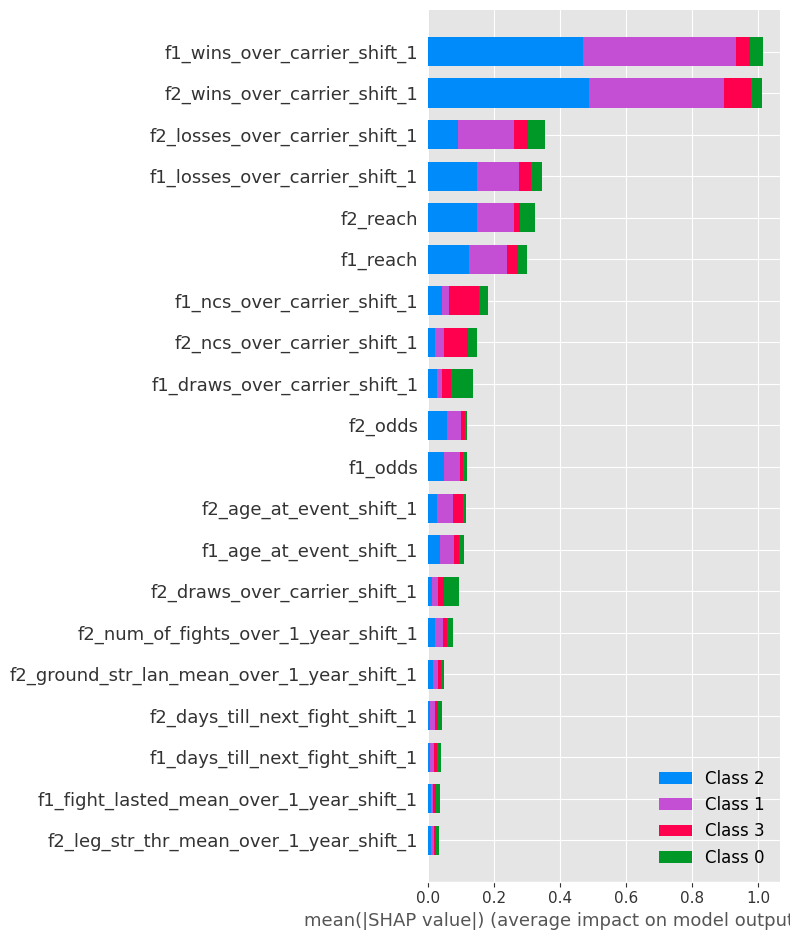

In [14]:
shap_values = shap.Explainer(CBC).shap_values(df_train[features])
shap.summary_plot(
    shap_values, 
    df_train[features],
    plot_type="bar",  
    max_display=20
)

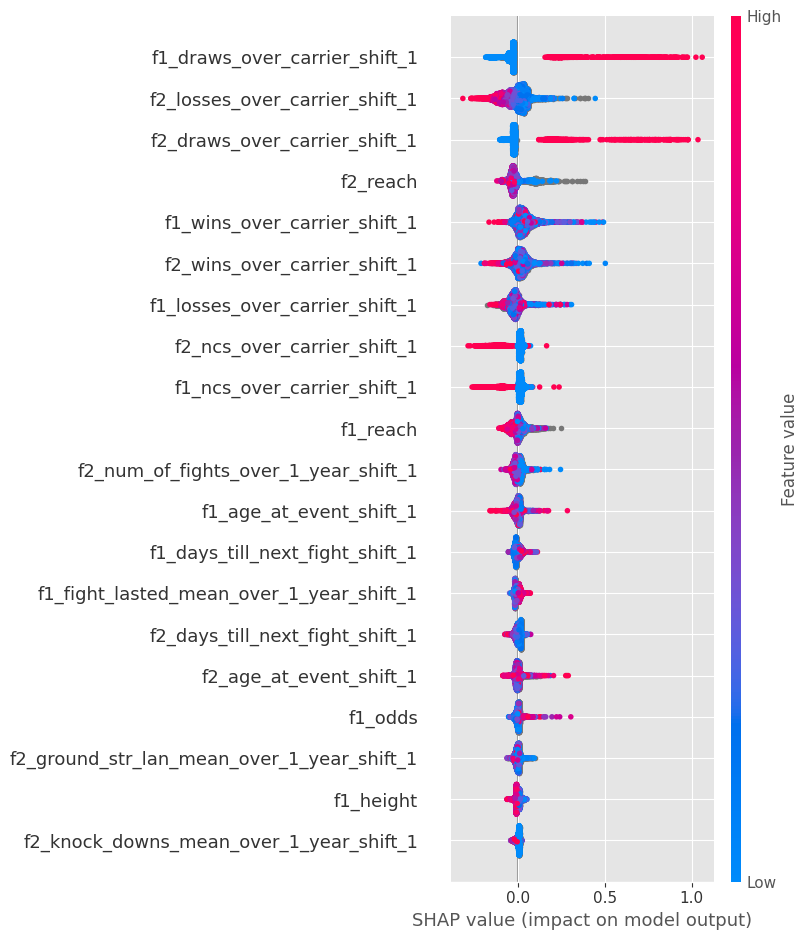

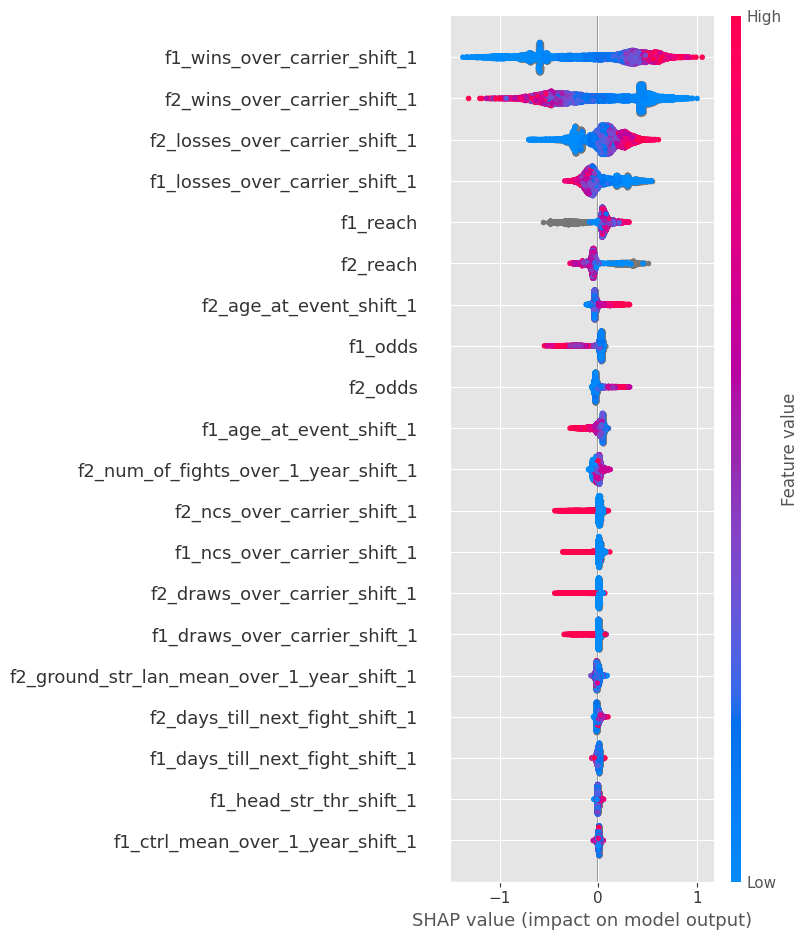

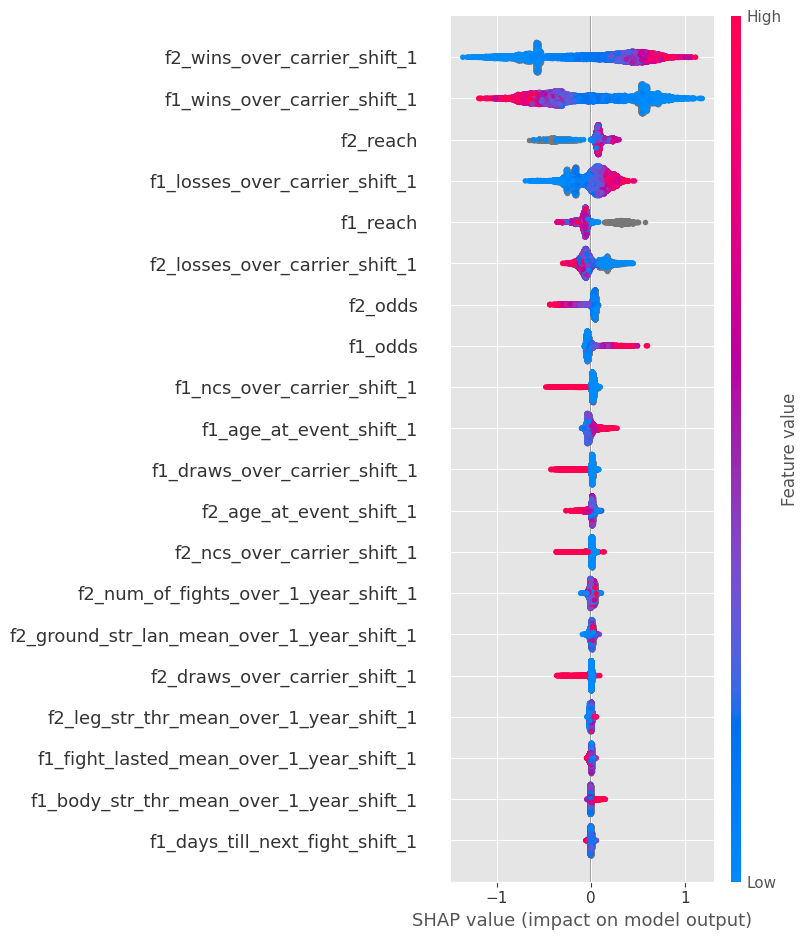

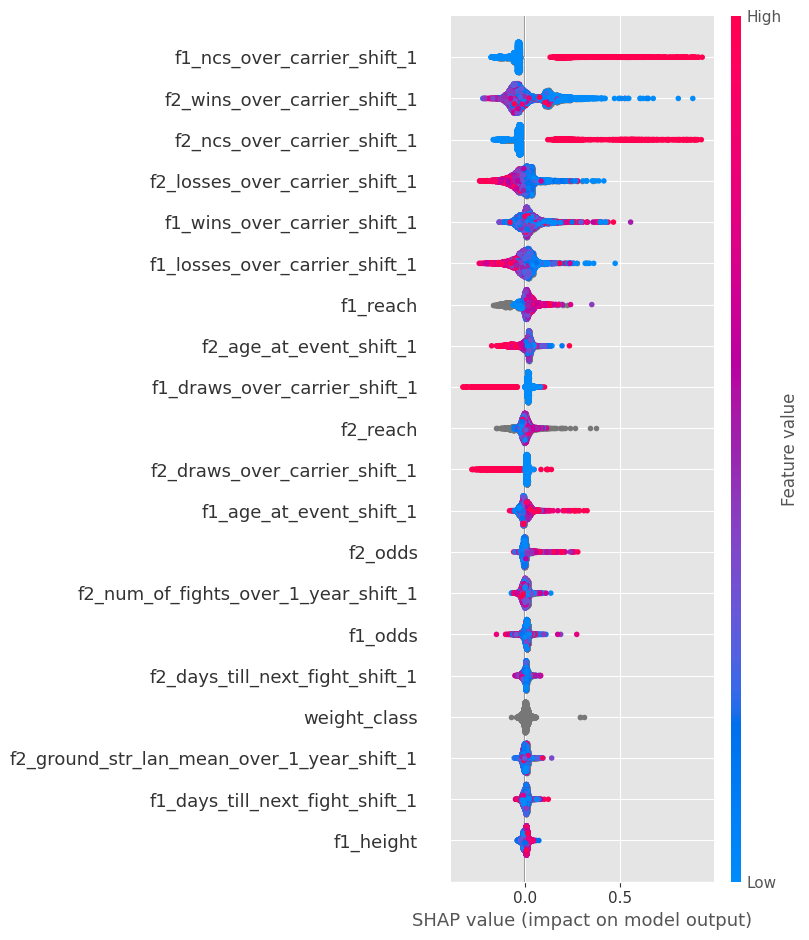

In [15]:
for i in range(4): 
    shap.summary_plot(
        shap_values[i],
        df_train[features],
        plot_type="dot"
    )

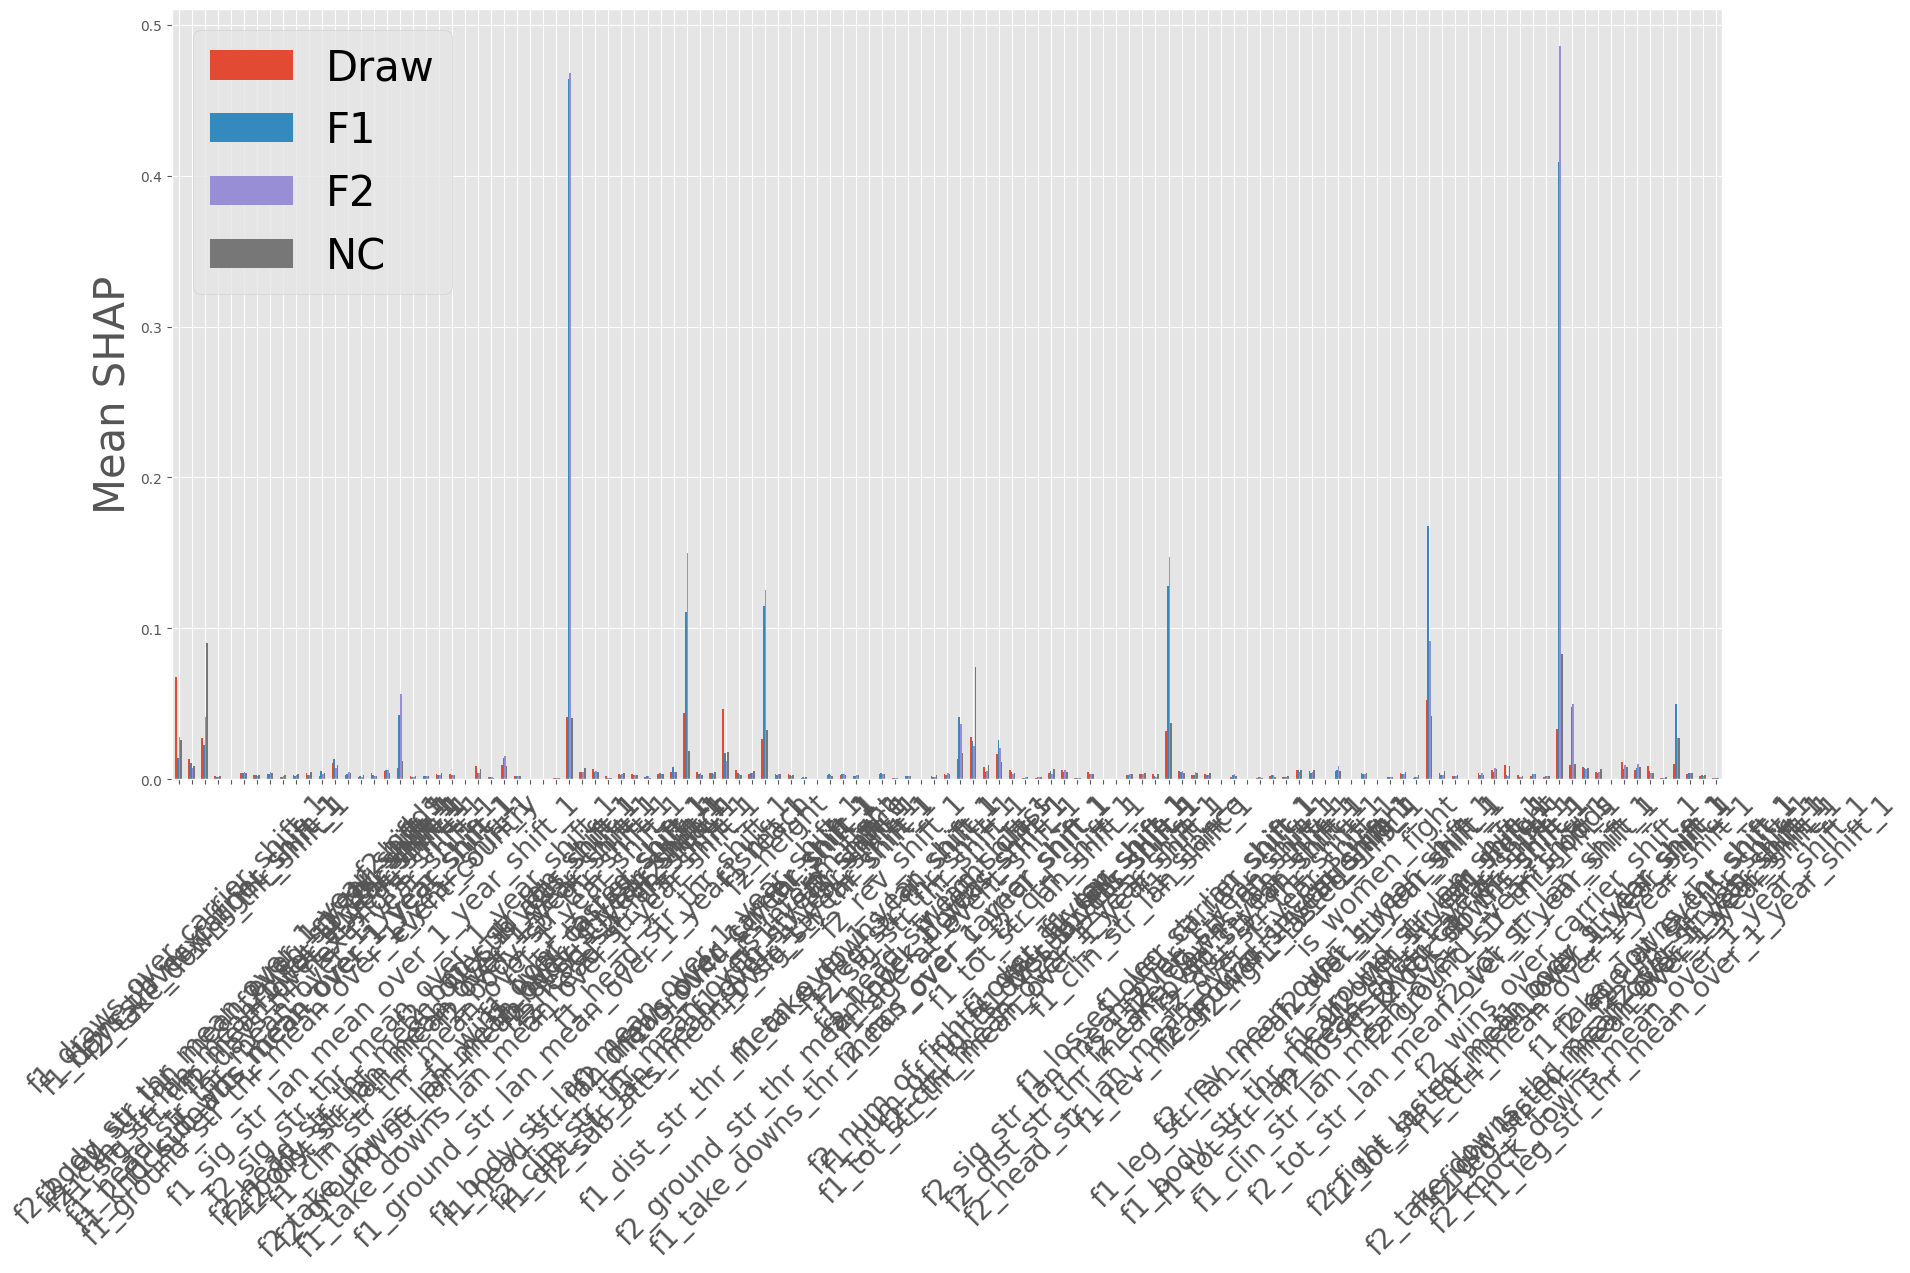

In [16]:
mean_0 = np.mean(np.abs(shap_values[0]), axis=0)
mean_1 = np.mean(np.abs(shap_values[1]), axis=0)
mean_2 = np.mean(np.abs(shap_values[2]), axis=0)
mean_3 = np.mean(np.abs(shap_values[3]), axis=0)

df = pd.DataFrame({"Draw": mean_0, "F1": mean_1, "F2": mean_2, "NC": mean_3})

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df.plot.bar(ax=ax)

ax.set_ylabel("Mean SHAP", size=30)
ax.set_xticklabels(features, rotation=45, size=20)
ax.legend(fontsize=30)